In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [3]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

Data was downloaded from https://www.science.org/doi/10.1126/science.aat1699

In [4]:
adata = sc.read_10x_mtx(
    '../data/aat1699_DataS1/',  # the directory with the `.mtx` file
    var_names='gene_symbols',   # use gene symbols for the variable names (variables-axis index)
    cache=True)                 # write a cache file for faster subsequent reading

... reading from cache file cache/..-data-aat1699_DataS1-matrix.h5ad


In [5]:
adata.var_names_make_unique()  # this is u'nnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 125139 × 33694
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


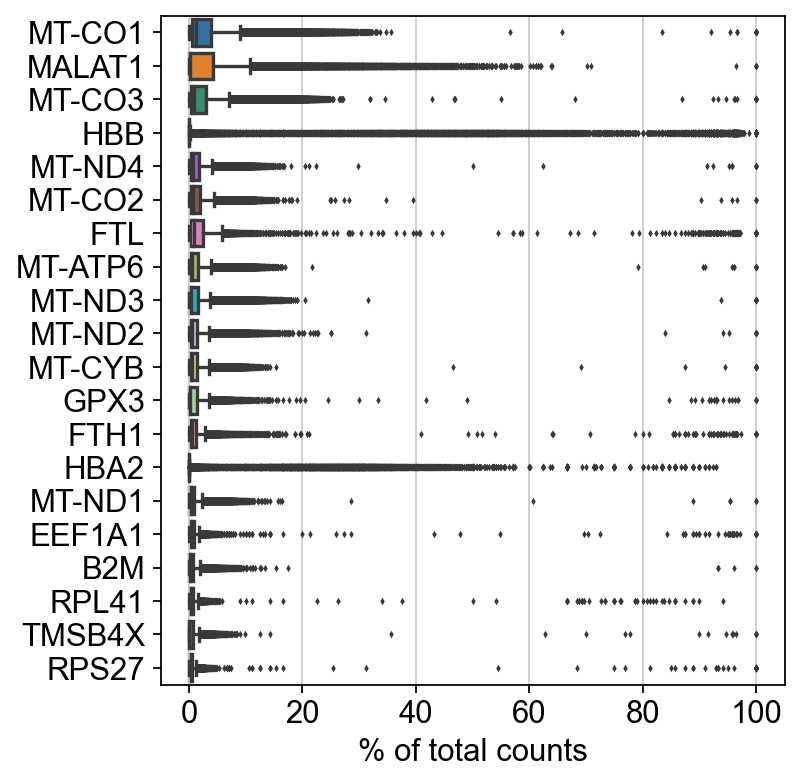

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 29314 cells that have less than 200 genes expressed
filtered out 6434 genes that are detected in less than 3 cells


In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

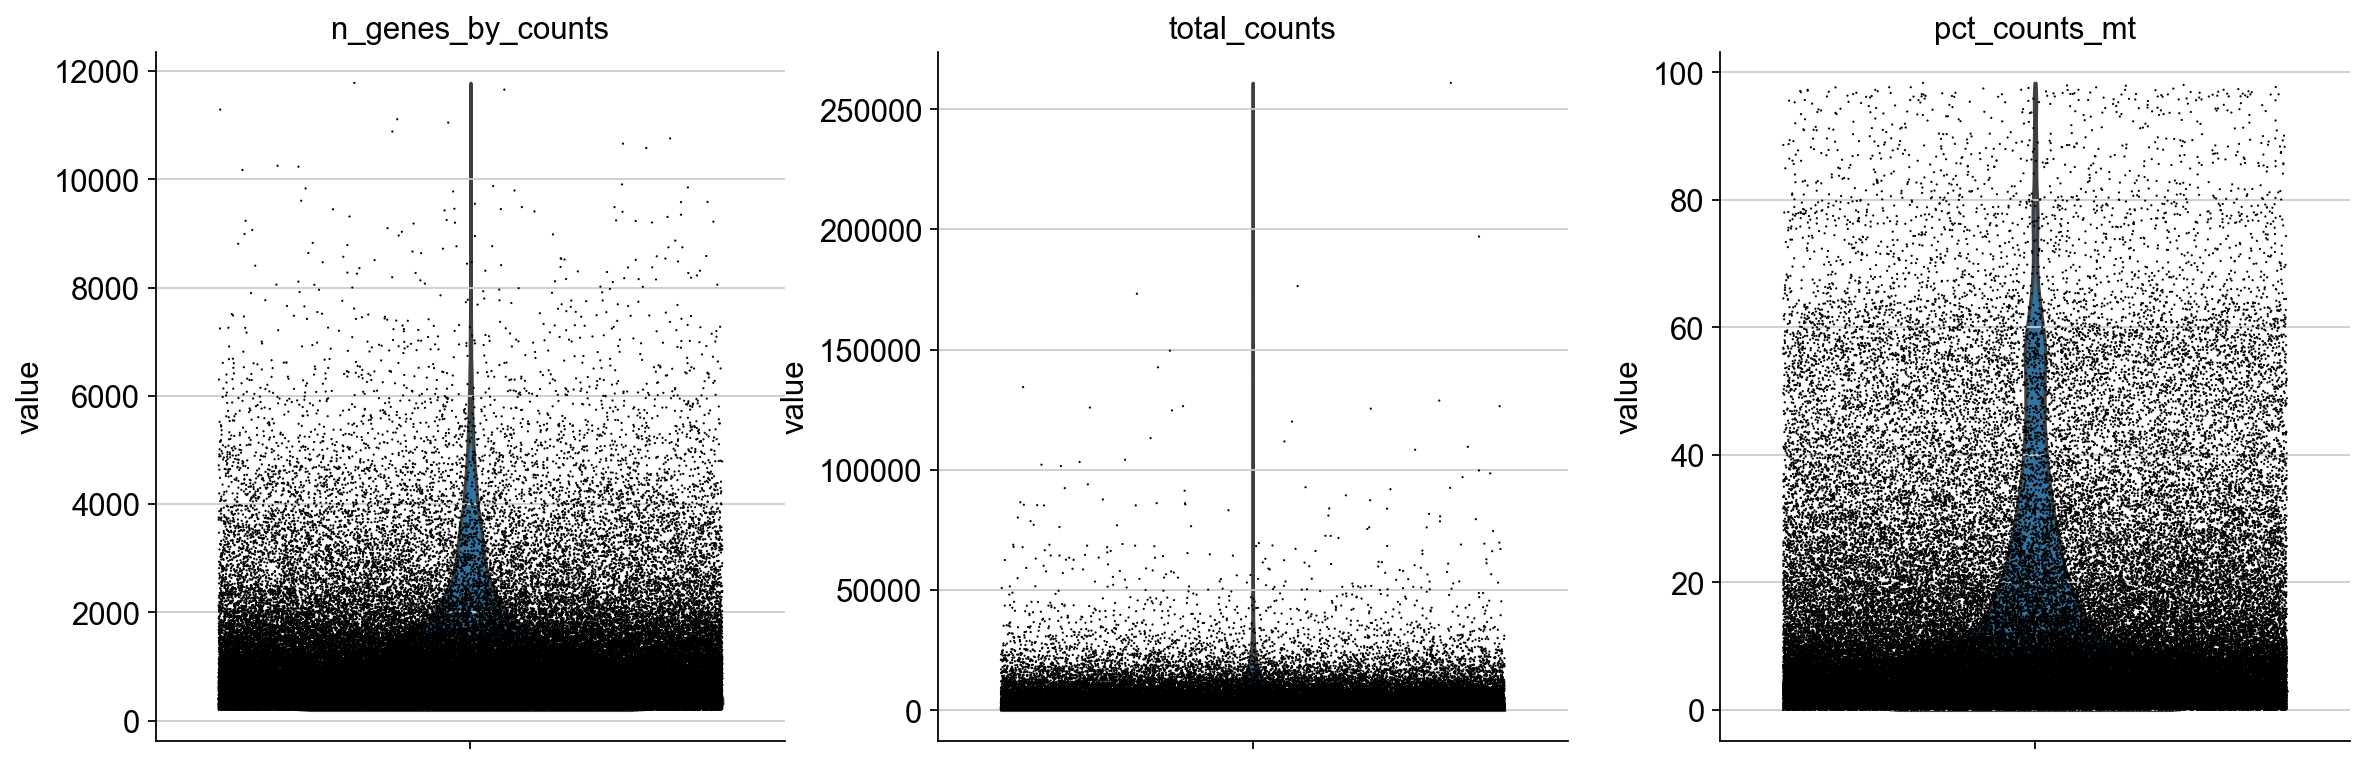

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

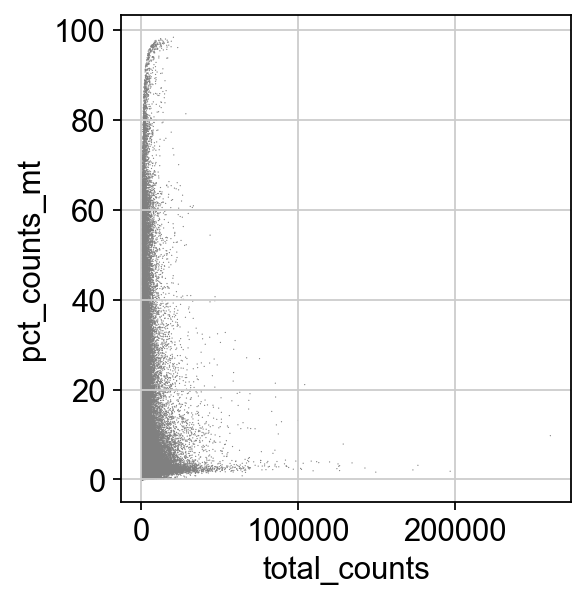

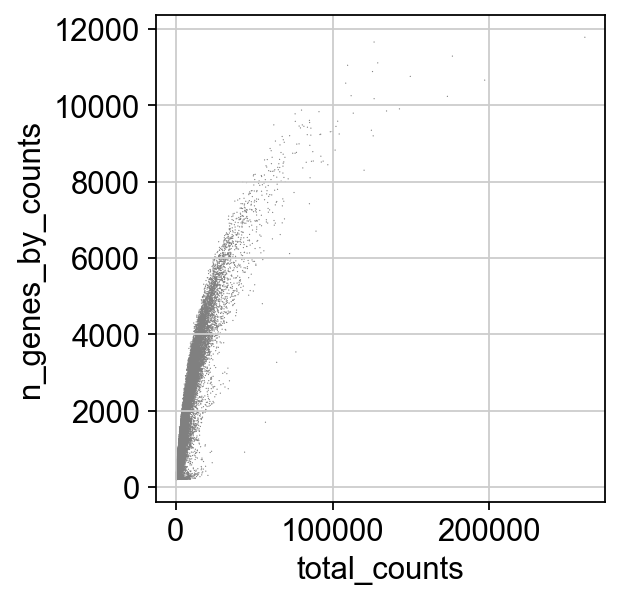

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


/Users/aureliendugourd/opt/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


In [14]:
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


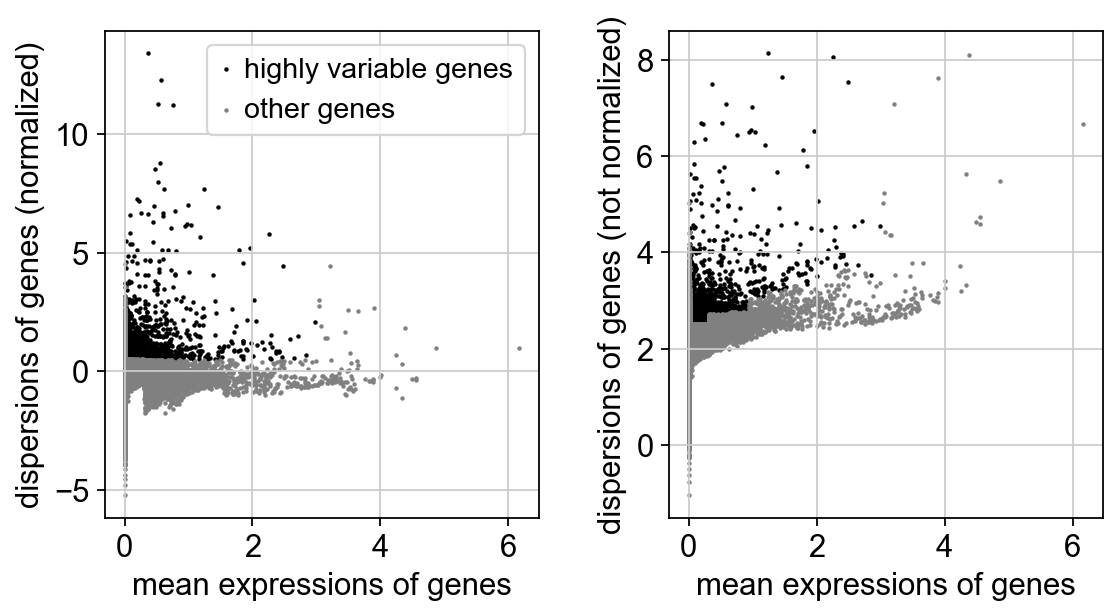

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.raw = adata

In [18]:
adata = adata[:, adata.var.highly_variable]

In [19]:
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [20]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/aureliendugourd/opt/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


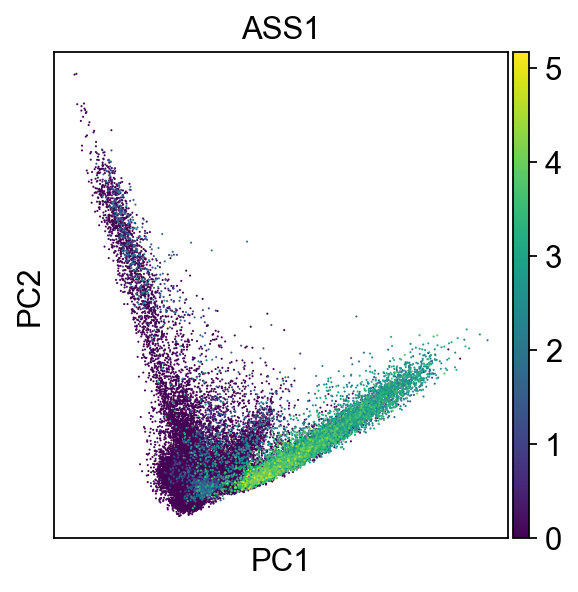

In [22]:
sc.pl.pca(adata, color='ASS1')

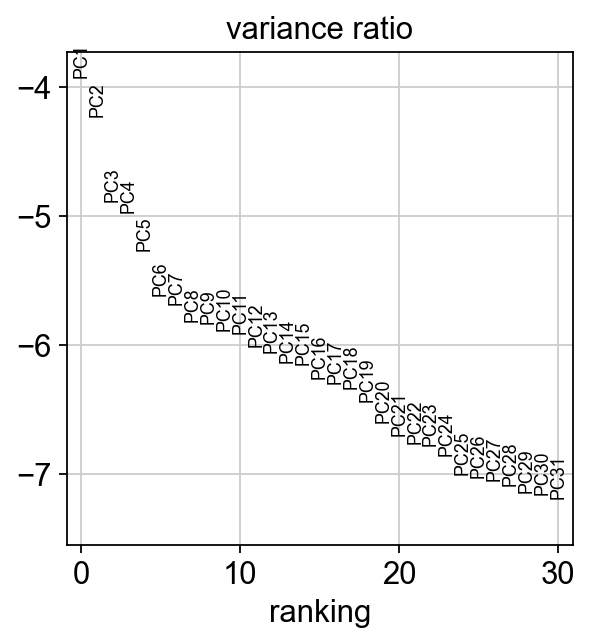

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [25]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)


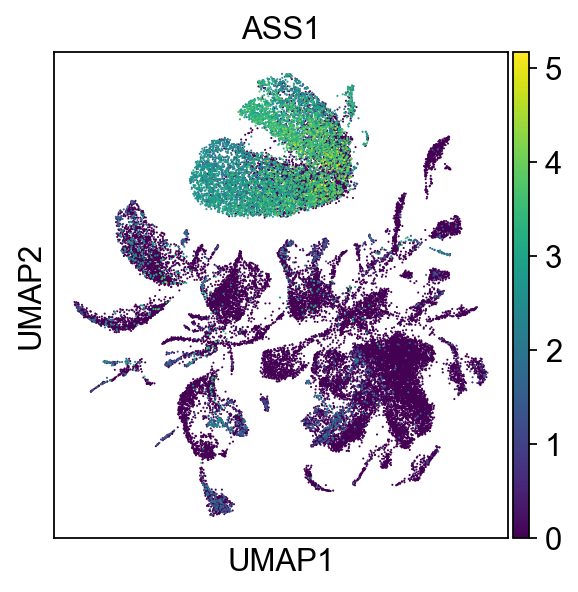

In [26]:
sc.pl.umap(adata, color=['ASS1'])

In [27]:
#sc.tl.leiden(adata)

In [28]:
# sc.pl.umap(adata, color=['leiden', 'ASS1'])

In [29]:
import pandas as pd

In [30]:
meta = pd.read_csv('../support/cell_annotations.csv', sep=";").set_index('DropletID')
# meta

In [31]:
# adata.obs

In [32]:
meta = meta.loc[adata.obs.index.intersection(meta.index)]

In [33]:
# meta

In [34]:
meta.Compartment.unique()

array(['Normal_Epithelium_and_Vascular_without_PT', 'Normal_Immune',
       'Normal_Proximal_Tubules', 'Indistinct',
       'Tumour_Epithelium_and_Vascular', 'Tumour_Immune',
       'Foetal_Epithelium_and_Vascular', 'Foetal_Immune'], dtype=object)

In [35]:
adata.obs = adata.obs.merge(meta, left_index=True, right_index=True)

In [36]:
adata_filtered = adata[np.isin(adata.obs.Compartment, ['Normal_Epithelium_and_Vascular_without_PT','Tumour_Epithelium_and_Vascular','Normal_Proximal_Tubules','Normal_Immune','Tumour_Immune']) & ["RCC" in i for i in list(adata.obs.Source)]].raw.to_adata()


In [37]:
adata_filtered

AnnData object with n_obs × n_vars = 17960 × 27260
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'barcode', 'SangerID', 'ClusterID', 'Compartment', 'nUMI', 'nGenes', 'MTfrac', 'QCpass', 'Source'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [38]:
sc.pp.highly_variable_genes(adata_filtered)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [39]:
adata_filtered.raw = adata_filtered
adata_filtered = adata_filtered[:, adata_filtered.var.highly_variable]

In [40]:
sc.pp.scale(adata_filtered, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/aureliendugourd/opt/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [41]:
sc.tl.pca(adata_filtered, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


In [42]:
sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [43]:
sc.tl.umap(adata_filtered)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


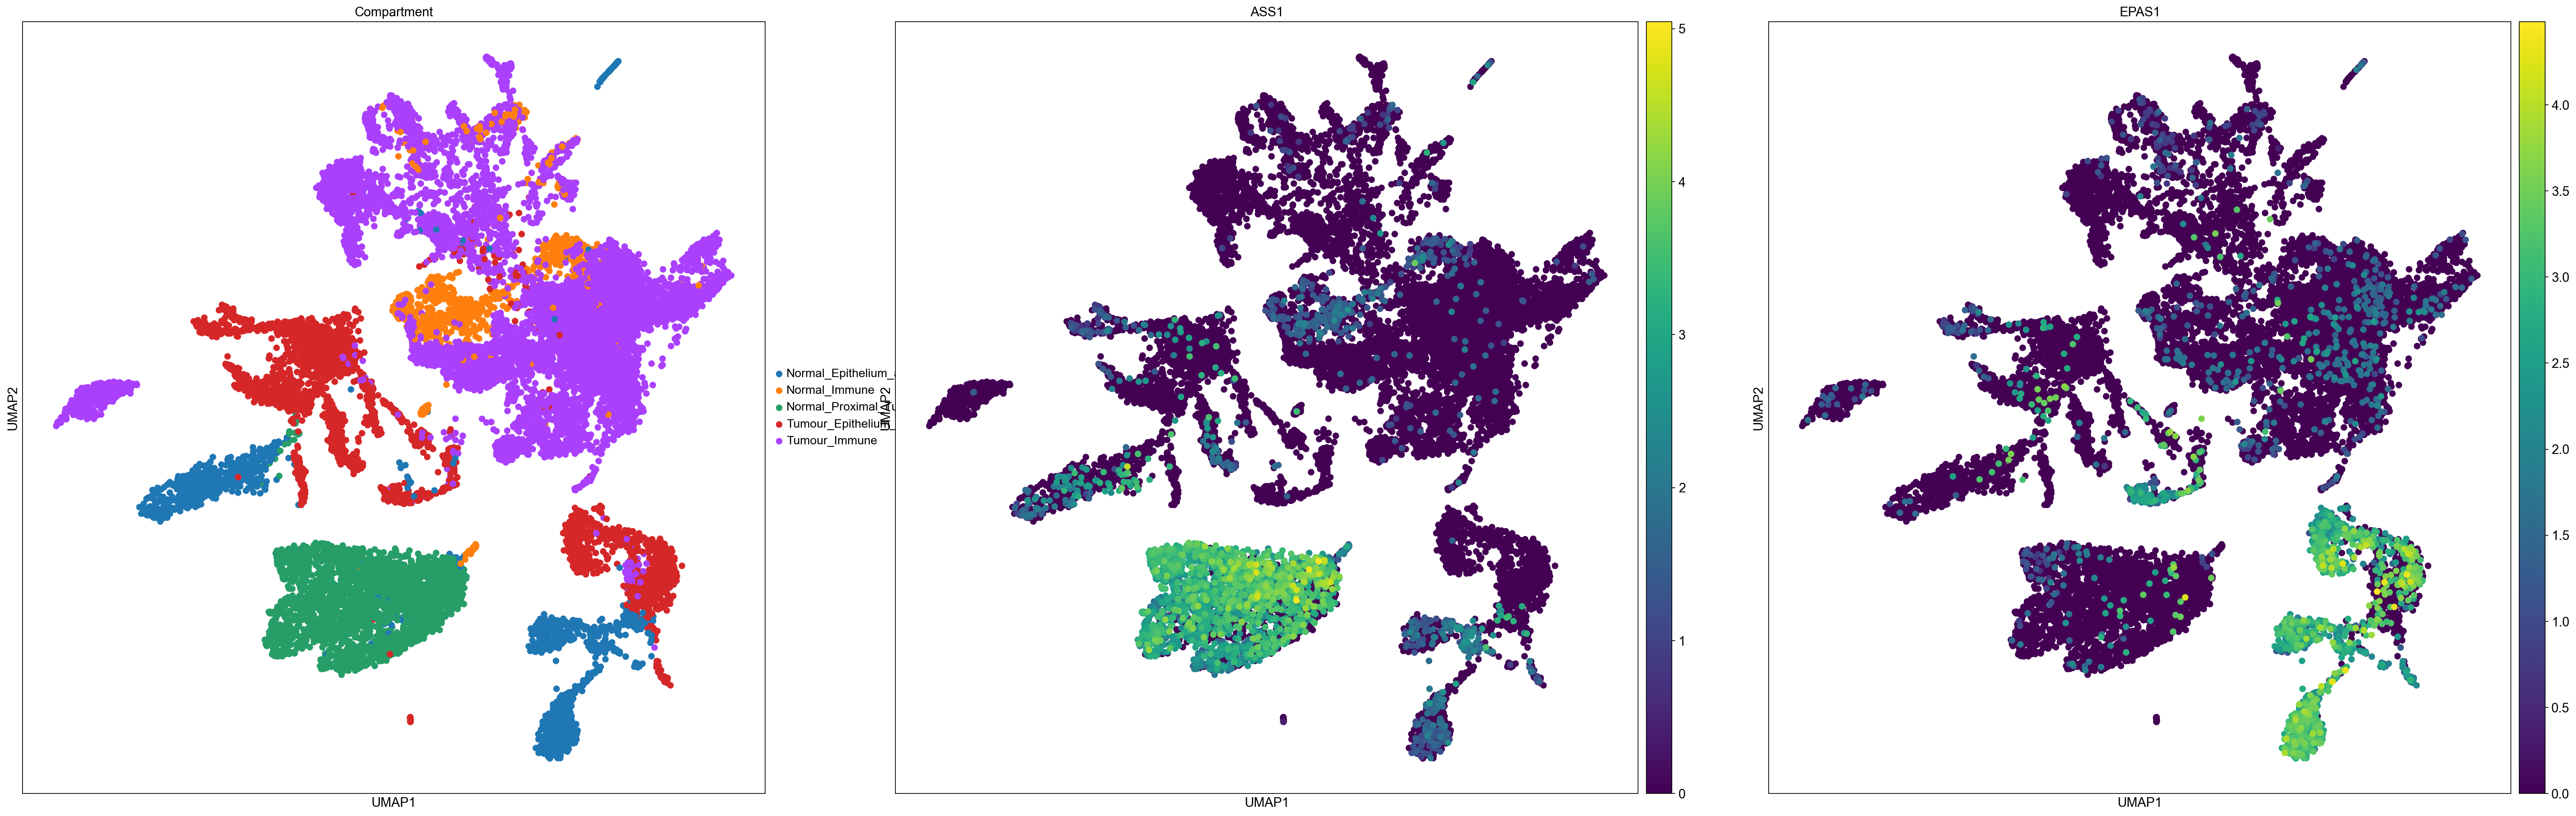

In [44]:
sc.set_figure_params(figsize=(15,15))
sc.pl.umap(adata_filtered, color=['Compartment', 'ASS1','EPAS1'], size=200)

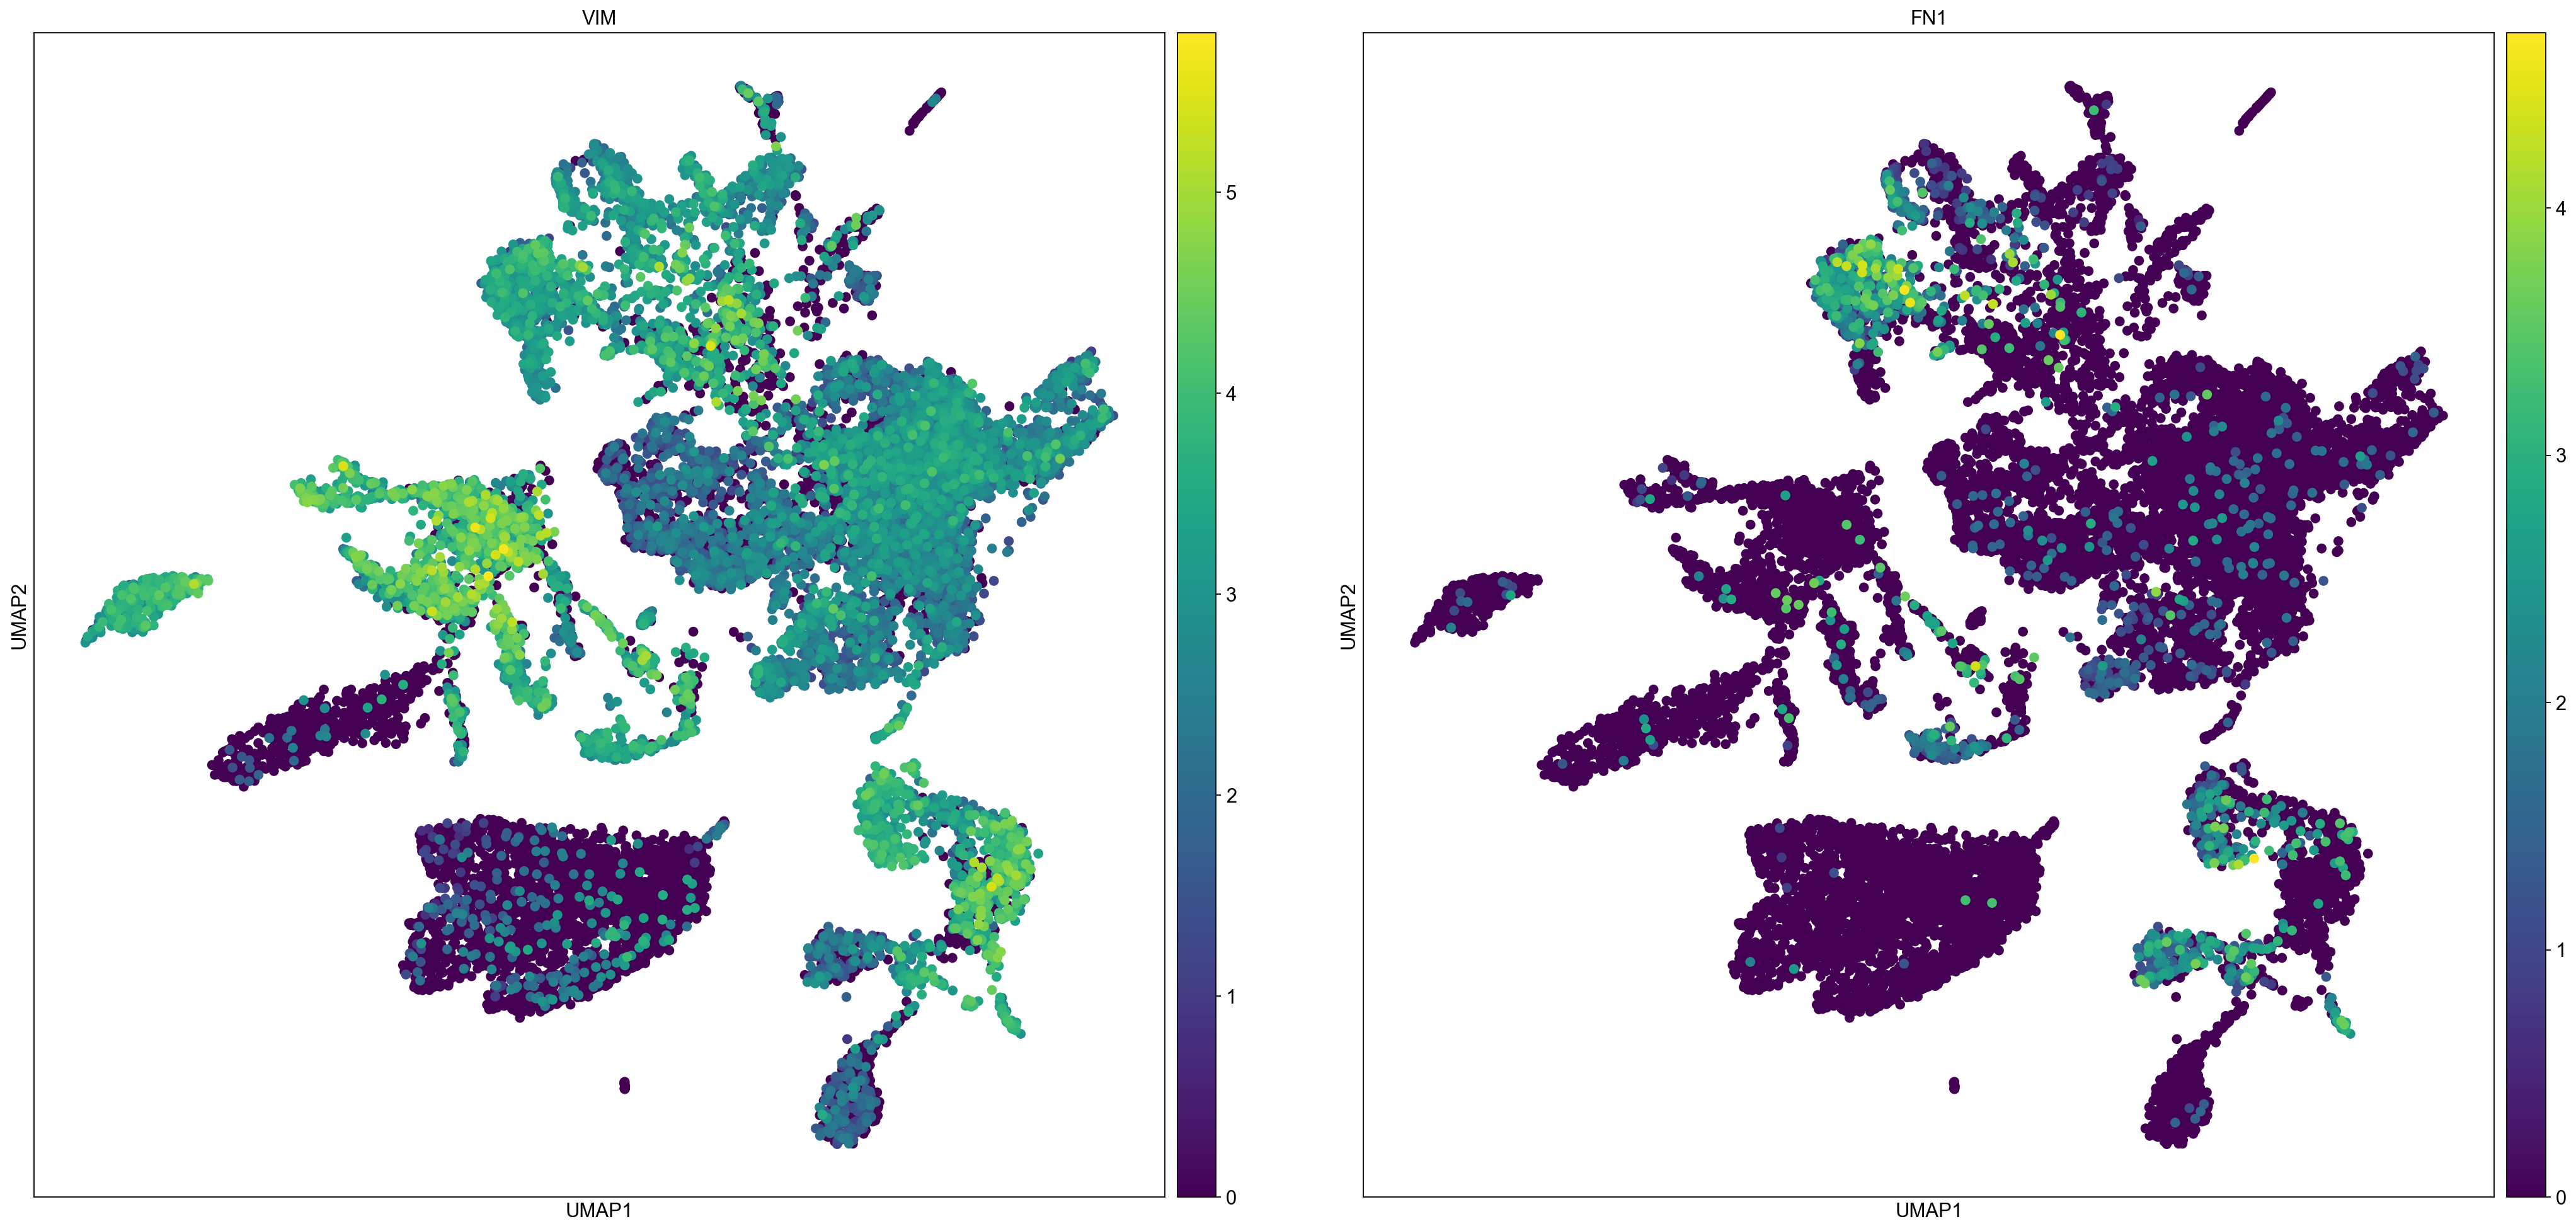

In [45]:
sc.pl.umap(adata_filtered, color=['VIM','FN1'], size=200)